In [4]:
from hossam import *

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)



In [5]:
origin = load_data("fish_processed")
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전


,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


In [6]:
yname = "무게"
x = origin.drop(columns=[yname])
y=origin[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42, 3), (14, 3), (42,), (14,))

# 하이퍼 파라미터 튜닝을 적용한 머신러닝

In [ ]:
#고정 파라미터는 모델 객체 생성시 설정
model = LinearRegression(n_jobs=-1)

#탐색할 하이퍼파라미터 그리도 설명
param_grid = {"fit_intercept": [True, False], "positive":[True, False]}

#그리드 서치 객체 생성
gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="r2")

gs.fit(x_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LinearRegression(n_jobs=-1)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'fit_intercept': [True, False], 'positive': [True, False]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 :

### 최적 모형

In [8]:
best_model= gs.best_estimator_
display(best_model)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",-1
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",True


### 최적 파라미터

In [9]:
gs.best_params_

{'fit_intercept': True, 'positive': True}

### 최고 성능 점수

In [10]:
gs.best_score_

np.float64(0.9208159625330845)

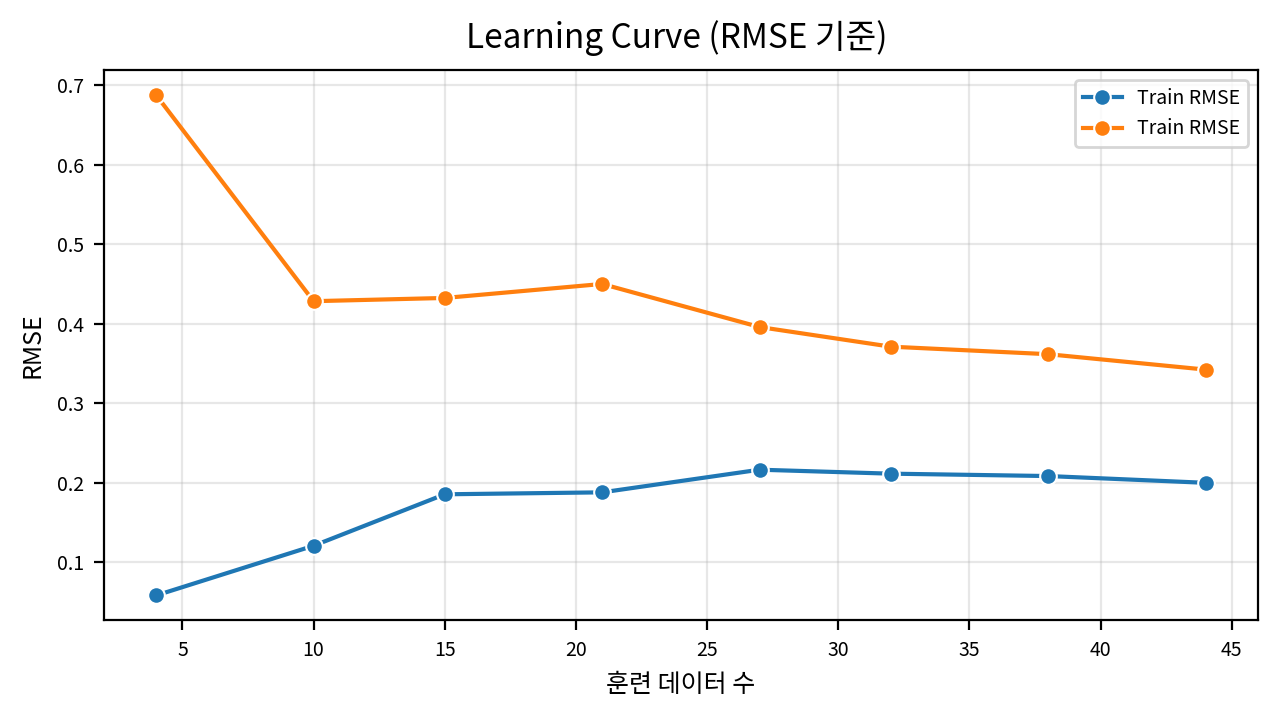

,지표,값
0,Train RMSE,0.200127
1,CV RMSE 평균,0.34239
2,CV RMSE 표준편차,0.211246
3,TRAIN/CV 비율,0.584502
4,CV 변동성 비율,0.616975
5,판정 결과,과대 적합 (일반화 실패)


In [14]:
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=best_model, 
    X=x,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True, 
    random_state=52,
)

train_rmse = -train_scores
cv_rmse = -cv_scores

# 평균/표준편차
train_mean = train_rmse.mean(axis=1)
cv_mean = cv_rmse.mean(axis=1)
cv_std = cv_rmse.std(axis=1)

#마지막 지점 기준 정량 판정
final_train = train_mean[-1]
final_cv= cv_mean[-1]
final_std = cv_std[-1]

gap_ratio = final_train/ final_cv
var_ratio = final_std/ final_cv

#--------------------------------------------------
#판정 로직
#--------------------------------------------------

if gap_ratio >=1.2 and var_ratio <=0.10:
    status = "과소적합 (모델이 너무 단순)"
elif gap_ratio <=0.9 and var_ratio >=0.20:
    status = "과대 적합 (일반화 실패)"
elif gap_ratio <=0.9 and var_ratio <=0.10:
    status="일반화 양호"
elif gap_ratio <=0.9 and var_ratio >0.10:
    status = "데이터 부족(표본 수 문제)"
else:
    status = "판단 유보"

#---------------------------------------------
#시각화
#---------------------------------------------
figsize = (1280/ my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize= figsize, dpi=my_dpi)

sb.lineplot(
    x=train_sizes,
    y=train_mean,
    marker="o",
    label="Train RMSE",
    ax=ax,

)
sb.lineplot(
    x=train_sizes,
    y=cv_mean,
    marker="o",
    label="Train RMSE",
    ax=ax,

)

ax.set_title("Learning Curve (RMSE 기준) ", fontsize=12, pad=8)
ax.set_xlabel("훈련 데이터 수", fontsize=9)
ax.set_ylabel("RMSE", fontsize=9)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
plt.close()

#-----------------------------------------------------------
# 정량 결과 표
#------------------------------------------------------
result_df = DataFrame(
    {
        "지표":[
            "Train RMSE",
            "CV RMSE 평균",
            "CV RMSE 표준편차",
            "TRAIN/CV 비율",
            "CV 변동성 비율",
            "판정 결과",
        ],
        "값":[
            final_train,
            final_cv,
            final_std,
            gap_ratio,
            var_ratio,
            status,
        ]
    }
)
result_df